In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import sys
import os
import logging as LOG

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_rel, wilcoxon
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split

from xgboost_utils import split_data,create_features,train_and_evaluate,train_and_evaluate_multiple_targets,plot_model_performance
color_pal = sns.color_palette()
plt.style.use( 'fivethirtyeight' )

In [32]:
# Cargar tu dataset (por ejemplo, desde un archivo CSV)
train_data = pd.read_csv("data/total_incomes_augmented_training_data.csv")
test_data = pd.read_csv("data/total_incomes_test_data.csv")

# # Concatenar los DataFrames
df = pd.concat([train_data, test_data], ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])

# # Ordenar el DataFrame por la columna 'Date' de más reciente a más antigua
df = df.sort_values(by='Date', ascending=True)

columnas_a_sumar = [
    'Pinar del Rio',
    'Artemisa',
    'La Habana',
    'Mayabeque',
    'Matanzas',
    'Villa Clara',
    'Cienfuegos',
    'Sancti Spiritus',
    'Ciego de Ávila',
    'Camagüey',
    'Las Tunas',
    'Holguin',
    'Granma',
    'Santiago de Cuba',
    'Guantánamo',
    'Isla de la Juventud'
    ]

df['total_aps_i_pais'] = df[columnas_a_sumar].sum(axis=1)

train_data ,test_data = split_data(df,0.8)

# # Seleccionar solo las columnas que te interesan
columnas_interes_provincias = [
    "Date",
    'Pinar del Rio',
    'Artemisa',
    'La Habana',
    'Mayabeque',
    'Matanzas',
    'Villa Clara',
    'Cienfuegos',
    'Sancti Spiritus',
    'Ciego de Ávila',
    'Camagüey',
    'Las Tunas',
    'Holguin',
    'Granma',
    'Santiago de Cuba',
    'Guantánamo',
    'Isla de la Juventud'
]

# Seleccionar solo las columnas que te interesan
columnas_interes_pais = ["Date",'total_aps_i_pais']

train_data_provincias = train_data[columnas_interes_provincias]
test_data_provincias = test_data[columnas_interes_provincias]

# Columnas objetivo
target_cols_provincia = ['Pinar del Rio','Artemisa','La Habana','Mayabeque','Matanzas','Villa Clara','Cienfuegos','Sancti Spiritus','Ciego de Ávila','Camagüey','Las Tunas','Holguin','Granma','Santiago de Cuba','Guantánamo','Isla de la Juventud']
target_cols_pais = ['total_aps_i_pais']

index = 1
# Generar características para entrenamiento y prueba
train_data_provincias = create_features(train_data_provincias, target_cols_provincia)
test_data_provincias = create_features(test_data_provincias, target_cols_provincia)


In [33]:
def train_and_evaluate_multiple_targets(train_data, test_data, target_cols, date_col='Date'):
    """
    Train and evaluate models for multiple target columns.

    This function trains a regression model for each target column in the dataset,
    using common features derived from the training dataset. The models are stored
    in a dictionary, along with their respective predictions.

    Args:
        train_data (pd.DataFrame): DataFrame containing the training dataset.
        test_data (pd.DataFrame): DataFrame containing the testing dataset.
        target_cols (list of str): List of target column names to predict.
        date_col (str): Column name to exclude from features. Default is 'Date'.

    Returns:
        tuple: A tuple containing:
            - models (dict): A dictionary where keys are target column names,
              and values are the trained models (XGBRegressor).
            - predictions (dict): A dictionary where keys are target column names,
              and values are arrays of rounded predictions for the test set.
    """
    # Define common features excluding the date column and target columns
    features = [col for col in train_data.columns if col not in [date_col] + target_cols]

    # Initialize dictionaries for models and predictions
    models = {}
    predictions = {}
    mses= [1]

    # Train and evaluate a model for each target column
    for target_col in target_cols:
        print(f'Entrenando modelo para: {target_col}')
        model, y_pred, rmse, mse, mae = train_and_evaluate(train_data, test_data, target_col, features)
        print(f'{target_col} - RMSE: {rmse}, MSE: {mse}, MAE: {mae}')
        models[target_col] = model
        predictions[target_col] = y_pred
        mses[0] = mse
    return models, predictions, mses

Pinar del Río

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Pinar del Rio
Pinar del Rio - RMSE: 19.457270256992846, MSE: 378.5853658536585, MAE: 15.560975609756097
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0061
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Pinar del Rio
Pinar del Rio - RMSE: 19.457270256992846, MSE: 378.5853658536585, MAE: 15.560975609756097
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0062
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Pinar del Rio
Pinar del Rio - RMSE: 19.457270256992846, MSE: 378.5853658536585, MAE: 15.560975609756097
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en e

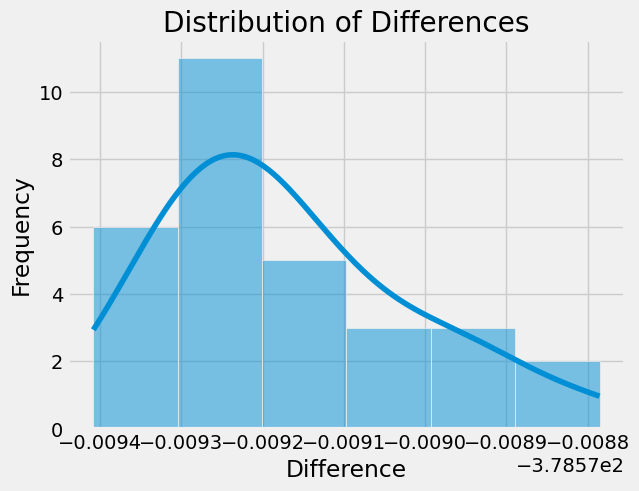

Paired t-test p-value: 3.368170119569933e-187
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [22]:

# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[0]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[0])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)

    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Artemisa

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Artemisa
Artemisa - RMSE: 11.426328177054783, MSE: 130.5609756097561, MAE: 8.75609756097561
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0011
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Artemisa
Artemisa - RMSE: 11.426328177054783, MSE: 130.5609756097561, MAE: 8.75609756097561
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0012
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Artemisa
Artemisa - RMSE: 11.426328177054783, MSE: 130.5609756097561, MAE: 8.75609756097561
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0011
Ejecuta

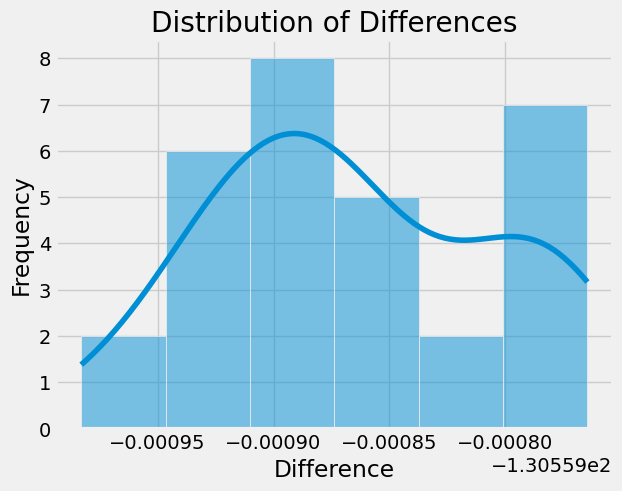

Paired t-test p-value: 2.4515811597399287e-185
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [36]:

# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 1
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

La Habana

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: La Habana
La Habana - RMSE: 29.702180259959402, MSE: 882.219512195122, MAE: 20.536585365853657
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0006
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: La Habana
La Habana - RMSE: 29.702180259959402, MSE: 882.219512195122, MAE: 20.536585365853657
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0006
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: La Habana
La Habana - RMSE: 29.702180259959402, MSE: 882.219512195122, MAE: 20.536585365853657
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.000

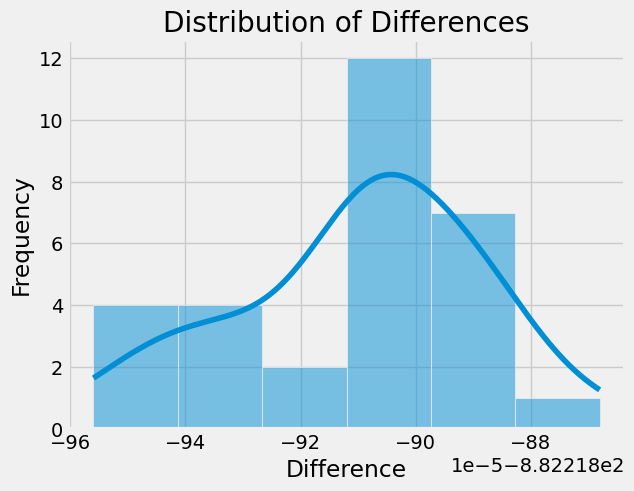

Paired t-test p-value: 8.868836990490967e-223
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [37]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    for i in range(num_runs):
        index = 2
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Mayabeque

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Mayabeque
Mayabeque - RMSE: 20.84378599569057, MSE: 434.4634146341463, MAE: 17.048780487804876
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0010
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Mayabeque
Mayabeque - RMSE: 20.84378599569057, MSE: 434.4634146341463, MAE: 17.048780487804876
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0010
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Mayabeque
Mayabeque - RMSE: 20.84378599569057, MSE: 434.4634146341463, MAE: 17.048780487804876
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.001

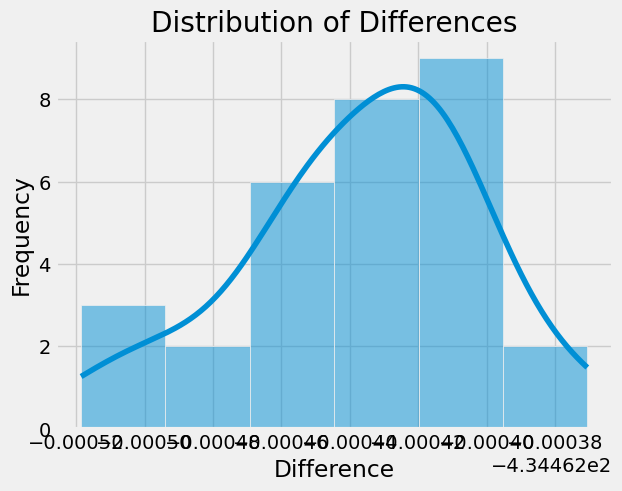

Paired t-test p-value: 1.0133109632808137e-207
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [38]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    for i in range(num_runs):
        index = 3
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Matanzas

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Matanzas
Matanzas - RMSE: 6.7045670637405905, MSE: 44.951219512195124, MAE: 5.390243902439025
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0003
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Matanzas
Matanzas - RMSE: 6.7045670637405905, MSE: 44.951219512195124, MAE: 5.390243902439025
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0003
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Matanzas
Matanzas - RMSE: 6.7045670637405905, MSE: 44.951219512195124, MAE: 5.390243902439025
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0003
E

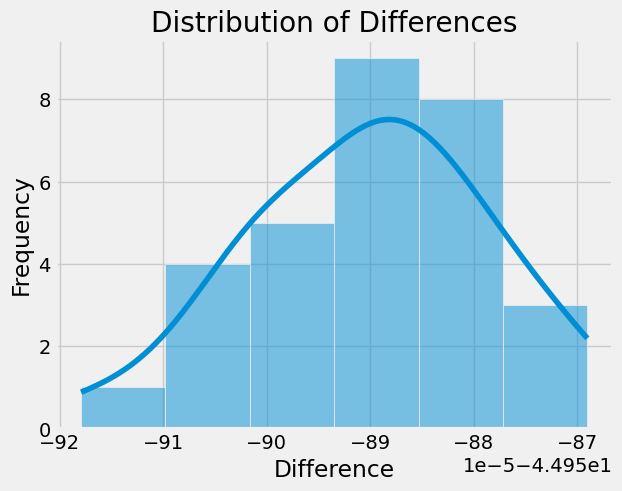

Paired t-test p-value: 8.762409024897234e-193
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [39]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 4
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Villa Clara

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Villa Clara
Villa Clara - RMSE: 37.94893873640621, MSE: 1440.121951219512, MAE: 30.682926829268293
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0071
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Villa Clara
Villa Clara - RMSE: 37.94893873640621, MSE: 1440.121951219512, MAE: 30.682926829268293
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0071
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Villa Clara
Villa Clara - RMSE: 37.94893873640621, MSE: 1440.121951219512, MAE: 30.682926829268293
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de p

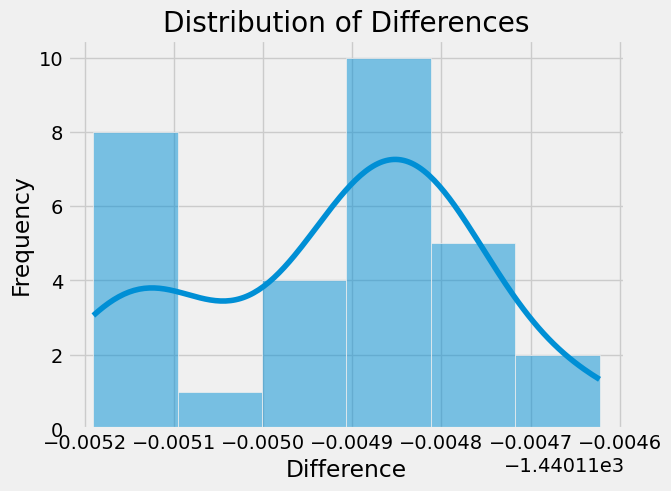

Paired t-test p-value: 1.0552482419449606e-203
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [40]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 5
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Cienfuegos

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Cienfuegos
Cienfuegos - RMSE: 103.90661848916872, MSE: 10796.585365853658, MAE: 29.878048780487806
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0019
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Cienfuegos
Cienfuegos - RMSE: 103.90661848916872, MSE: 10796.585365853658, MAE: 29.878048780487806
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0019
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Cienfuegos
Cienfuegos - RMSE: 103.90661848916872, MSE: 10796.585365853658, MAE: 29.878048780487806
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de p

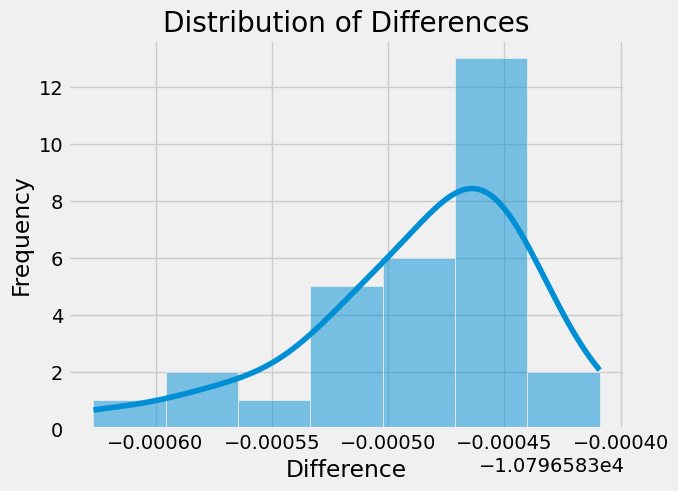

Wilcoxon test p-value: 1.862645149230957e-09
The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).
Based on the MSE values, the better model is: RNN


In [41]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 6
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Sancti Spiritus

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Sancti Spiritus
Sancti Spiritus - RMSE: 36.38748109567087, MSE: 1324.0487804878048, MAE: 28.024390243902438
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0032
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Sancti Spiritus
Sancti Spiritus - RMSE: 36.38748109567087, MSE: 1324.0487804878048, MAE: 28.024390243902438
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0033
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Sancti Spiritus
Sancti Spiritus - RMSE: 36.38748109567087, MSE: 1324.0487804878048, MAE: 28.024390243902438
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])


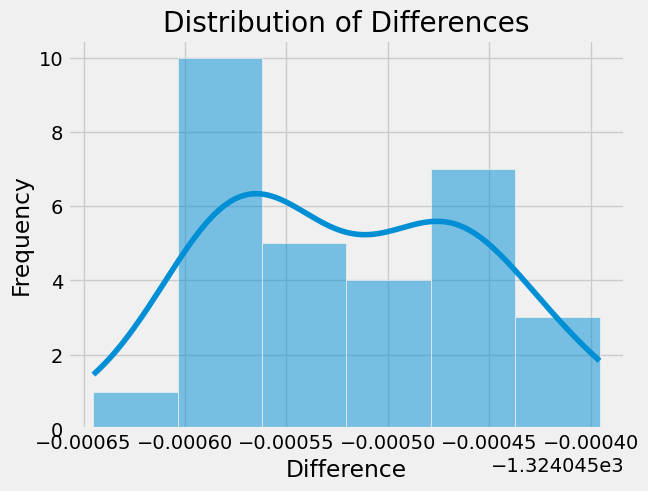

Paired t-test p-value: 8.126354180591159e-214
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [42]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 7
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Ciego de Ávila

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Ciego de Ávila
Ciego de Ávila - RMSE: 37.31474566310803, MSE: 1392.3902439024391, MAE: 29.26829268292683
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0021
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Ciego de Ávila
Ciego de Ávila - RMSE: 37.31474566310803, MSE: 1392.3902439024391, MAE: 29.26829268292683
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0021
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Ciego de Ávila
Ciego de Ávila - RMSE: 37.31474566310803, MSE: 1392.3902439024391, MAE: 29.26829268292683
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida e

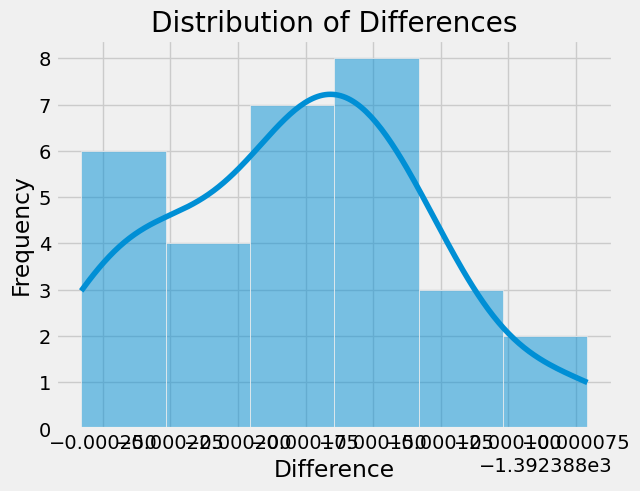

Paired t-test p-value: 2.484542598603665e-218
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [43]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 8
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Camagüey

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Camagüey
Camagüey - RMSE: 48.34757289542102, MSE: 2337.487804878049, MAE: 42.73170731707317
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0055
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Camagüey
Camagüey - RMSE: 48.34757289542102, MSE: 2337.487804878049, MAE: 42.73170731707317
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0056
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Camagüey
Camagüey - RMSE: 48.34757289542102, MSE: 2337.487804878049, MAE: 42.73170731707317
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0055
Ejecuta

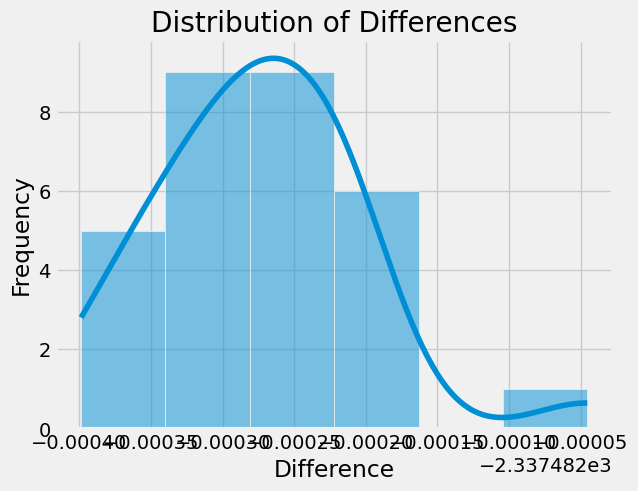

Paired t-test p-value: 1.2469608586051994e-219
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [44]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 9
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Las Tunas

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Las Tunas
Las Tunas - RMSE: 36.0347054934545, MSE: 1298.5, MAE: 25.597560975609756
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0057
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Las Tunas
Las Tunas - RMSE: 36.0347054934545, MSE: 1298.5, MAE: 25.597560975609756
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0056
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Las Tunas
Las Tunas - RMSE: 36.0347054934545, MSE: 1298.5, MAE: 25.597560975609756
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0058
Ejecutando XGBoost - Iteración 4
E

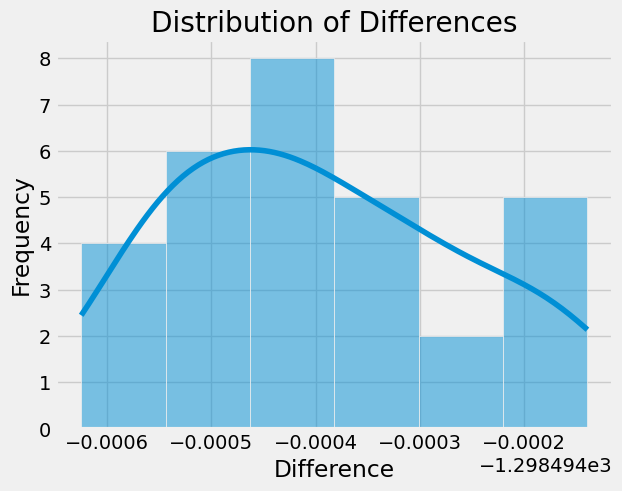

Paired t-test p-value: 3.910091626949823e-204
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [45]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 10
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Holguin

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Holguin
Holguin - RMSE: 64.2995087793701, MSE: 4134.426829268293, MAE: 50.23170731707317
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0046
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Holguin
Holguin - RMSE: 64.2995087793701, MSE: 4134.426829268293, MAE: 50.23170731707317
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0046
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Holguin
Holguin - RMSE: 64.2995087793701, MSE: 4134.426829268293, MAE: 50.23170731707317
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0046
Ejecutando XGBoo

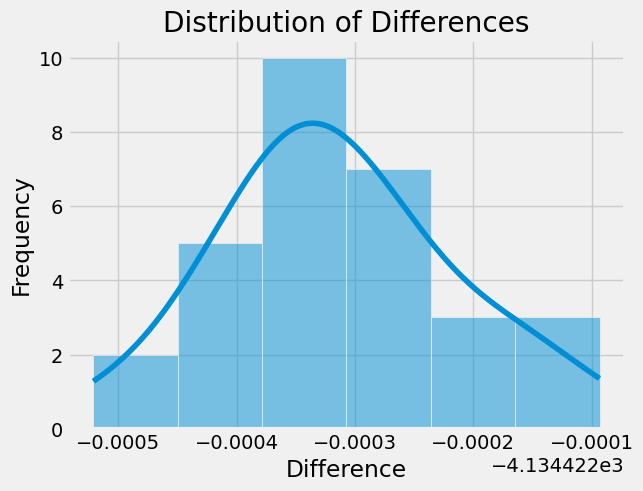

Paired t-test p-value: 8.683076065726622e-223
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [46]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 11
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Granma

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Granma
Granma - RMSE: 44.89119637740926, MSE: 2015.219512195122, MAE: 35.048780487804876
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0057
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Granma
Granma - RMSE: 44.89119637740926, MSE: 2015.219512195122, MAE: 35.048780487804876
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0058
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Granma
Granma - RMSE: 44.89119637740926, MSE: 2015.219512195122, MAE: 35.048780487804876
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0061
Ejecutando XGBoo

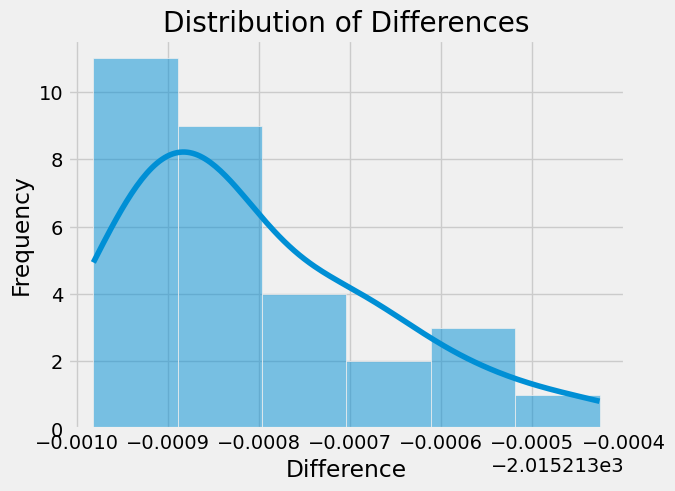

Wilcoxon test p-value: 1.862645149230957e-09
The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).
Based on the MSE values, the better model is: RNN


In [47]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 12
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Santiago de Cuba

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Santiago de Cuba
Santiago de Cuba - RMSE: 203.92074620231094, MSE: 41583.670731707316, MAE: 83.1829268292683
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0032
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Santiago de Cuba
Santiago de Cuba - RMSE: 203.92074620231094, MSE: 41583.670731707316, MAE: 83.1829268292683
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0032
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Santiago de Cuba
Santiago de Cuba - RMSE: 203.92074620231094, MSE: 41583.670731707316, MAE: 83.1829268292683
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1

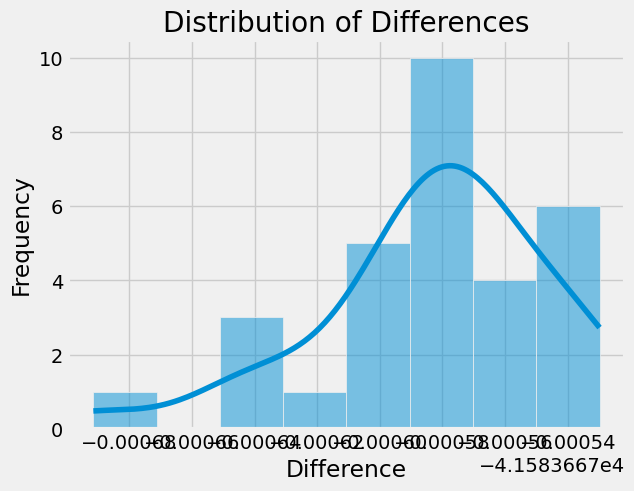

Paired t-test p-value: 1.8061412481128349e-264
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [48]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index =13
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Guantánamo

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Guantánamo
Guantánamo - RMSE: 17.838024608998037, MSE: 318.1951219512195, MAE: 12.658536585365853
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0030
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Guantánamo
Guantánamo - RMSE: 17.838024608998037, MSE: 318.1951219512195, MAE: 12.658536585365853
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0030
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Guantánamo
Guantánamo - RMSE: 17.838024608998037, MSE: 318.1951219512195, MAE: 12.658536585365853
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prue

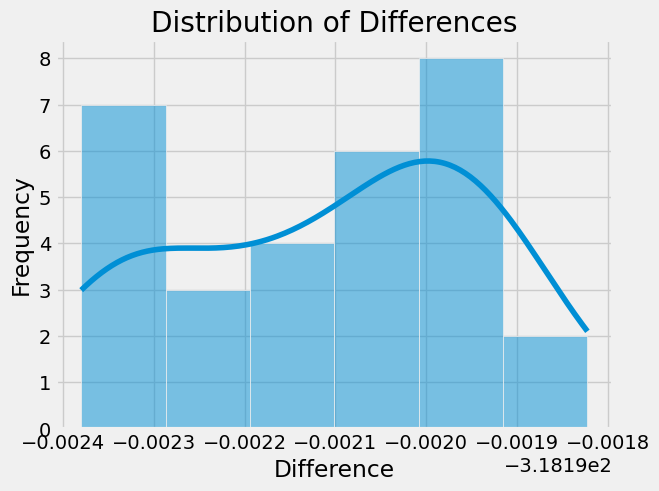

Paired t-test p-value: 7.870430452623871e-184
The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).
Based on the MSE values, the better model is: RNN


In [49]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 14
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()

Isla de la Juventud

Ejecutando XGBoost - Iteración 1
Entrenando modelo para: Isla de la Juventud
Isla de la Juventud - RMSE: 5.438121985732512, MSE: 29.573170731707318, MAE: 1.9146341463414633
Ejecutando la RNN - Iteración 1
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0038
Ejecutando XGBoost - Iteración 2
Entrenando modelo para: Isla de la Juventud
Isla de la Juventud - RMSE: 5.438121985732512, MSE: 29.573170731707318, MAE: 1.9146341463414633
Ejecutando la RNN - Iteración 2
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: torch.Size([183, 10, 1])
Pérdida en el conjunto de prueba: 0.0037
Ejecutando XGBoost - Iteración 3
Entrenando modelo para: Isla de la Juventud
Isla de la Juventud - RMSE: 5.438121985732512, MSE: 29.573170731707318, MAE: 1.9146341463414633
Ejecutando la RNN - Iteración 3
Cantidad de datos a entrenar: torch.Size([427, 10, 1])
Cantidad de datos a testear: t

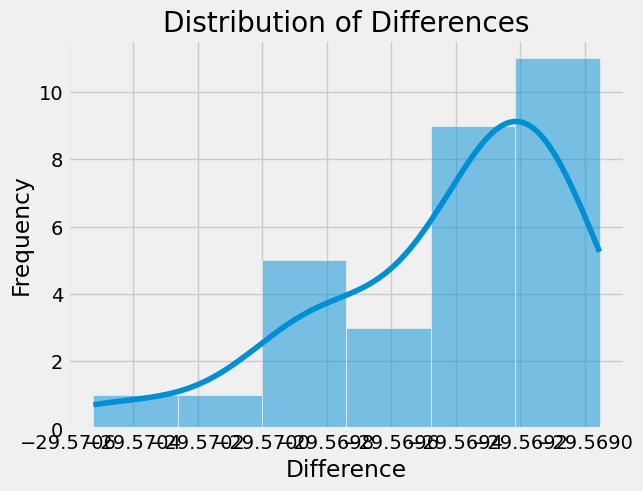

Wilcoxon test p-value: 1.862645149230957e-09
The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).
Based on the MSE values, the better model is: RNN


In [50]:
# log_directory = os.path.join(os.path.dirname(__file__), "logs")

# LOG.basicConfig(
#     level=LOG.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         LOG.FileHandler(os.path.join(log_directory, "rnn_logs.txt"), mode="w")  # Guarda logs en un archivo
#     ]
# )

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)


def RNN(df, timesteps, target_column, test_size=0.3, random_state=42,
        rnn_input_size=1, rnn_hidden_size=16, rnn_output_size=1, epochs=200):

    scaler = MinMaxScaler()
    df[target_column] = scaler.fit_transform(df[[target_column]])
    data = df[target_column].values
    X, Y = create_sequences(data, timesteps)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"Cantidad de datos a entrenar: {X_train.shape}")
    print(f"Cantidad de datos a testear: {X_test.shape}")

    model = SimpleRNN(rnn_input_size, rnn_hidden_size, rnn_output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            LOG.info(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = criterion(y_pred, y_test)
        print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")

    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    return y_test_inv, y_pred_inv, test_loss.item()


def metrics(y_test_inv, y_pred_inv):
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    LOG.info(f"MSE: {mse:.6f}")
    LOG.info(f"R2 Score: {r2:.6f}")
    return mse, r2

def main():
    path = os.path.abspath(os.path.join(
                                        "data/Anexos_7/full/total_incomes_augmented_full_data.csv"))
    df = pd.read_csv(path)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    torch.manual_seed(42)
    np.random.seed(42)


    num_runs = 30
    errors = []

    mse_rnn = []
    mse_xgb = []
    index = 15
    for i in range(num_runs):
        print(f"Ejecutando XGBoost - Iteración {i + 1}")
        models,predictions_provincias, mse =train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, [target_cols_provincia[index]])
        mse_xgb.append(mse[0])

        print(f"Ejecutando la RNN - Iteración {i + 1}")
        _, _, mse = RNN(df, timesteps=10, target_column=target_cols_provincia[index])
        mse_rnn.append(mse)


    # Calculate differences
    differences = np.array(mse_rnn) - np.array(mse_xgb)
    index +=1
    # Check normality of differences
    stat, p_value_normality = shapiro(differences)
    print(f'Normality test p-value: {p_value_normality}')

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Choose the appropriate test based on normality test result
    if p_value_normality > 0.05:
      # Perform paired t-test
      t_stat, p_value_ttest = ttest_rel(mse_rnn, mse_xgb)
      print(f'Paired t-test p-value: {p_value_ttest}')

      if p_value_ttest < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (paired t-test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (paired t-test).")
    else:
      # Perform Wilcoxon Signed-Rank Test
      w_stat, p_value_wilcoxon = wilcoxon(mse_rnn, mse_xgb)
      print(f'Wilcoxon test p-value: {p_value_wilcoxon}')

      if p_value_wilcoxon < 0.05:
        print("The difference between the RNN and XGBoost models' MSEs is statistically significant (Wilcoxon test).")
        print("Based on the MSE values, the better model is:", "RNN" if np.mean(mse_rnn) < np.mean(mse_xgb) else "XBBoost")
      else:
        print("There is no significant difference between the RNN and XGBoost models' MSEs (Wilcoxon test).")


if __name__ == "__main__":
    main()